In [37]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points

# julho


 Faltam os dias 3, 4, 5, 6, 12, 19, 26, 27

In [38]:
julho = pd.read_csv('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/passengers_julho.csv',
                    index_col= 'Unnamed: 0')

    #  Sao 214k linhas

In [39]:
julho

,timestampI,timestampF,MAC,RSSI,channel,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,id,device_id,duration
0,1625124487,1625124494,f0:b5:d1:5d:08:6e,-42,11,-22.816117,-47.072760,-22.816467,-47.072818,12,0,NaN,7
1,1625124487,1625124493,0c:ef:af:d3:00:1e,-50,11,-22.816117,-47.072760,-22.816412,-47.072808,5,1,NaN,6
2,1625124489,1625124489,0c:f4:d5:15:84:e8,-70,1,-22.816188,-47.072782,-22.816188,-47.072782,2,2,NaN,0
3,1625124494,1625124494,5c:cf:7f:a4:84:9c,-57,11,-22.816467,-47.072818,-22.816467,-47.072818,2,3,NaN,0
4,1625124495,1625124495,e0:10:7f:2e:04:98,-77,6,-22.816513,-47.072823,-22.816513,-47.072823,2,4,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258638,1627673252,1627673252,a8:16:d0:e3:83:89,-84,5,-22.816417,-47.072804,-22.816417,-47.072804,13,395,NaN,0
258639,1627673253,1627673253,16:aa:a1:63:04:92,-85,12,-22.816416,-47.072803,-22.816416,-47.072803,4,396,NaN,0
258640,1627673257,1627673257,fa:f7:31:db:e6:6f,-90,9,-22.816414,-47.072801,-22.816414,-47.072801,3,397,NaN,0
258641,1627673259,1627673260,06:46:fc:e0:7e:3f,-92,2,-22.816412,-47.072801,-22.816411,-47.072800,8,398,NaN,1



## Preparacao dos dados

In [40]:
julho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258643 entries, 0 to 258642
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestampI  258643 non-null  int64  
 1   timestampF  258643 non-null  int64  
 2   MAC         258643 non-null  object 
 3   RSSI        258643 non-null  int64  
 4   channel     258643 non-null  int64  
 5   latitudeI   258643 non-null  float64
 6   longitudeI  258643 non-null  float64
 7   latitudeF   258643 non-null  float64
 8   longitudeF  258643 non-null  float64
 9   cnt_pckg    258643 non-null  int64  
 10  id          258643 non-null  int64  
 11  device_id   140853 non-null  float64
 12  duration    258643 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 27.6+ MB


In [41]:
## Tranforma timestamp em datas

julho['dataInicio'] = pd.to_datetime(julho['timestampI'], unit='s')
julho['dataFim'] = pd.to_datetime(julho['timestampF'], unit='s')

In [42]:
julho = julho[['MAC','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'cnt_pckg', 'duration', 'dataInicio', 'dataFim']]

In [43]:
## Cria a coluna com o dia de cada ping para os agrupamentos

julho['day'] = julho.dataInicio.dt.day

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/538612140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['day'] = julho.dataInicio.dt.day


In [44]:
julho.drop(index = julho[ julho.dataInicio.dt.day  !=  julho.dataFim.dt.day ].index , inplace = True)
julho.reset_index(drop = True)

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/1330389691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho.drop(index = julho[ julho.dataInicio.dt.day  !=  julho.dataFim.dt.day ].index , inplace = True)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1
1,0c:ef:af:d3:00:1e,-22.816117,-47.072760,-22.816412,-47.072808,5,6,2021-07-01 07:28:07,2021-07-01 07:28:13,1
2,0c:f4:d5:15:84:e8,-22.816188,-47.072782,-22.816188,-47.072782,2,0,2021-07-01 07:28:09,2021-07-01 07:28:09,1
3,5c:cf:7f:a4:84:9c,-22.816467,-47.072818,-22.816467,-47.072818,2,0,2021-07-01 07:28:14,2021-07-01 07:28:14,1
4,e0:10:7f:2e:04:98,-22.816513,-47.072823,-22.816513,-47.072823,2,0,2021-07-01 07:28:15,2021-07-01 07:28:15,1
...,...,...,...,...,...,...,...,...,...,...
258624,a8:16:d0:e3:83:89,-22.816417,-47.072804,-22.816417,-47.072804,13,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30
258625,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30
258626,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30
258627,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30


In [45]:
## Cria coluna de ID para cada um dos MACS para facilitar identificacao

MACs_unicos = julho.MAC.unique()

temp = defaultdict(lambda: len(temp))
device_id = [temp[ele] for ele in MACs_unicos]

res = dict(zip(MACs_unicos, device_id))

julho['device_id'] = julho['MAC'].map(res)
julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/1907121458.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['device_id'] = julho['MAC'].map(res)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0
1,0c:ef:af:d3:00:1e,-22.816117,-47.072760,-22.816412,-47.072808,5,6,2021-07-01 07:28:07,2021-07-01 07:28:13,1,1
2,0c:f4:d5:15:84:e8,-22.816188,-47.072782,-22.816188,-47.072782,2,0,2021-07-01 07:28:09,2021-07-01 07:28:09,1,2
3,5c:cf:7f:a4:84:9c,-22.816467,-47.072818,-22.816467,-47.072818,2,0,2021-07-01 07:28:14,2021-07-01 07:28:14,1,3
4,e0:10:7f:2e:04:98,-22.816513,-47.072823,-22.816513,-47.072823,2,0,2021-07-01 07:28:15,2021-07-01 07:28:15,1,4
...,...,...,...,...,...,...,...,...,...,...,...
258638,a8:16:d0:e3:83:89,-22.816417,-47.072804,-22.816417,-47.072804,13,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,11861
258639,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428
258640,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429
258641,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430


In [46]:
## Adiciona sequence para identificar dentro de um dia de qual a o numero da conexao atual (em uma lista ordenada)

julho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)

julho['sequence'] = julho.groupby(['device_id', 'day']).cumcount()+1

julho.reset_index(drop = True, inplace = True)

julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/3862337680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho.sort_values(by= ['device_id', 'dataInicio'], inplace = True)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/3862337680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['sequence'] = julho.groupby(['device_id', 'day']).cumcount()+1


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
258624,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1
258625,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1
258626,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1
258627,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1


In [47]:
julho['periodo'] = None

julho.loc[julho['dataInicio'].dt.hour <= 12, 'periodo'] =  'Manha'
julho.loc[julho['dataInicio'].dt.hour > 12, 'periodo'] =  'Tarde'
julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/2762215349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['periodo'] = None


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1,Manha
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2,Manha
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3,Manha
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4,Manha
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5,Manha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258624,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1,Tarde
258625,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1,Tarde
258626,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1,Tarde
258627,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1,Tarde


In [48]:

##### OUTDATED #####

## Criando coluna de duracao da conexao entre os pings



julho['duration(s)'] = (julho['dataFim'] - julho['dataInicio']).dt.total_seconds()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/2991512990.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['duration(s)'] = (julho['dataFim'] - julho['dataInicio']).dt.total_seconds()


In [49]:
## funcao de calculo de distancia entre o ponto de inicio e fim da conexao

def haversine_vectorize(lon1, lat1, lon2, lat2):
    # print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6_367_000 * dist #6367 for distance in KM for miles use 3958
    return m

julho['distance(m)'] = julho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


julho

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1655/457696729.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  julho['distance(m)'] = julho.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)
0,f0:b5:d1:5d:08:6e,-22.816117,-47.072760,-22.816467,-47.072818,12,7,2021-07-01 07:28:07,2021-07-01 07:28:14,1,0,1,Manha,7.0,47.213886
1,f0:b5:d1:5d:08:6e,-22.816290,-47.072612,-22.816483,-47.072838,2,1676,2021-07-01 07:31:22,2021-07-01 07:59:18,1,0,2,Manha,1676.0,37.868753
2,f0:b5:d1:5d:08:6e,-22.816298,-47.072655,-22.815973,-47.072783,224,2530,2021-07-01 08:10:05,2021-07-01 08:52:15,1,0,3,Manha,2530.0,46.106250
3,f0:b5:d1:5d:08:6e,-22.816291,-47.072668,-22.816490,-47.072747,105,2117,2021-07-01 09:03:08,2021-07-01 09:38:25,1,0,4,Manha,2117.0,28.257496
4,f0:b5:d1:5d:08:6e,-22.816172,-47.072777,-22.816473,-47.072794,7,8,2021-07-01 11:02:31,2021-07-01 11:02:39,1,0,5,Manha,8.0,40.192745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258624,b2:b4:bf:5a:ea:ea,-22.816417,-47.072804,-22.816417,-47.072804,3,0,2021-07-30 19:27:32,2021-07-30 19:27:32,30,91427,1,Tarde,0.0,0.000000
258625,16:aa:a1:63:04:92,-22.816416,-47.072803,-22.816416,-47.072803,4,0,2021-07-30 19:27:33,2021-07-30 19:27:33,30,91428,1,Tarde,0.0,0.000000
258626,fa:f7:31:db:e6:6f,-22.816414,-47.072801,-22.816414,-47.072801,3,0,2021-07-30 19:27:37,2021-07-30 19:27:37,30,91429,1,Tarde,0.0,0.000000
258627,06:46:fc:e0:7e:3f,-22.816412,-47.072801,-22.816411,-47.072800,8,1,2021-07-30 19:27:39,2021-07-30 19:27:40,30,91430,1,Tarde,1.0,0.181358


In [50]:
## Coluna de velocidade media para avalicao se os movimentos sao coerentes

# julho['velMed(km/h)'] = julho['distance(m)']/julho['duration(s)'] *3.6

# julho


In [51]:
# julho[['lat1', 'long1']] = julho[['latitudeF', 'longitudeF']].shift(1)

# julho['distance_lagged(m)'] = julho.apply(lambda x : haversine_vectorize(x['long1'], x['lat1'], x['longitudeI'], x['latitudeI']), axis = 1)

# julho

In [52]:
julho.loc[(julho['MAC'] == "40:06:a0:5b:8c:b2")   & (julho['day']== 1) ]

,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)


In [53]:
julho.loc[(julho['day']== 1) ]['MAC'].value_counts()

f0:b5:d1:5d:08:6e    16
5c:cf:7f:a4:84:9c    16
0c:ef:af:d3:00:1e    16
1c:bf:ce:10:59:ac    14
e0:10:7f:6e:00:68    13
                     ..
9c:e6:5e:45:47:e3     1
da:a1:19:6d:e6:ed     1
3a:99:14:aa:76:42     1
06:f8:70:bd:ce:22     1
60:d0:2c:60:46:43     1
Name: MAC, Length: 4523, dtype: int64

## Agrupamentio dos usuarios por dias contando numero de conexoes

Aqui pode haver mais coisas a se fazer

Como eh possivel ver no caso do dia=1 device=0
 - a data de inicio eh no dia 1, e a data fim eh no dia 2
 - isso nao acontece pra todos os devices, mas para os que acontecem pode ser retrabalhado

In [54]:
julho_group = julho.groupby(['day','device_id', 'periodo']).agg({
                                                        'dataInicio': 'min',
                                                        'dataFim':'max',
                                                        'sequence':'count',
                                                        'distance(m)':'sum'
                                                        ,'duration(s)':'sum'
})
# julho_group.loc[:,'distance(m)']  = julho_group['distance(m)'] + julho_group['distance_lagged(m)']
# julho_group.drop(labels = ['distance_lagged(m)'],inplace=True, axis = 1)

# julho_group['duration(s)'] = (julho_group['dataFim'] - julho_group['dataInicio']).dt.total_seconds()

julho_group

dataInicio             dataFim  sequence  \
day device_id periodo                                                     
1   0         Manha   2021-07-01 07:28:07 2021-07-01 13:17:09         8   
              Tarde   2021-07-01 13:36:18 2021-07-01 19:27:37         8   
    1         Manha   2021-07-01 07:28:07 2021-07-01 13:17:09         8   
              Tarde   2021-07-01 13:36:18 2021-07-01 19:27:37         8   
    2         Manha   2021-07-01 07:28:09 2021-07-01 13:15:49         7   
...                                   ...                 ...       ...   
30  91427     Tarde   2021-07-30 19:27:32 2021-07-30 19:27:32         1   
    91428     Tarde   2021-07-30 19:27:33 2021-07-30 19:27:33         1   
    91429     Tarde   2021-07-30 19:27:37 2021-07-30 19:27:37         1   
    91430     Tarde   2021-07-30 19:27:39 2021-07-30 19:27:40         1   
    91431     Tarde   2021-07-30 19:27:44 2021-07-30 19:27:44         1   

                       distance(m)  duration(s)  
day device_id periodo                            
1   0         Manha     406.206379      13010.0  
              Tarde     466.319406      14508.0  
    1         Manha     350.406441      12994.0  
              Tarde     469.909436      14500.0  
    2         Manha      51.648950       3259.0  
...                            ...          ...  
30  91427     Tarde       0.000000          0.0  
    91428     Tarde       0.000000          0.0  
    91429     Tarde       0.000000          0.0  
    91430     Tarde       0.181358          1.0  
    91431     Tarde       0.000000          0.0  

[162670 rows x 5 columns]

#### Recuperando a primeira e ultima coordenada

 - Usando o usuario/MAC e o primeiro e ultimo momento em conexao
 - Buscar as coordenadas desses dispositivos nesse instante (inicial e final)
 - Comparar com a coordenada dos pontos de onibus para determinar qual o ponto de embarque do passageiro e ponto de desembarque

In [55]:


julho_coordenadas = julho_group.merge(julho[['day','device_id', 'periodo', 'dataInicio', 'latitudeI', 'longitudeI']],  
                                        right_on= ['day', 'device_id', 'periodo', 'dataInicio'], 
                                        left_on=  ['day','device_id',  'periodo','dataInicio']).merge(
                                            julho[['day','device_id', 'periodo','dataFim', 'latitudeF', 'longitudeF']],  
                                            right_on= ['day', 'device_id', 'periodo','dataFim'], 
                                            left_on=  ['day','device_id',  'periodo','dataFim'])


julho_coordenadas

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,1,0,Manha,2021-07-01 07:28:07,2021-07-01 13:17:09,8,406.206379,13010.0,-22.816117,-47.072760,-22.816437,-47.072837
1,1,0,Tarde,2021-07-01 13:36:18,2021-07-01 19:27:37,8,466.319406,14508.0,-22.815734,-47.072599,-22.816604,-47.072880
2,1,1,Manha,2021-07-01 07:28:07,2021-07-01 13:17:09,8,350.406441,12994.0,-22.816117,-47.072760,-22.816437,-47.072837
3,1,1,Tarde,2021-07-01 13:36:18,2021-07-01 19:27:37,8,469.909436,14500.0,-22.815734,-47.072599,-22.816604,-47.072880
4,1,2,Manha,2021-07-01 07:28:09,2021-07-01 13:15:49,7,51.648950,3259.0,-22.816188,-47.072782,-22.816430,-47.072911
...,...,...,...,...,...,...,...,...,...,...,...,...
163502,30,91427,Tarde,2021-07-30 19:27:32,2021-07-30 19:27:32,1,0.000000,0.0,-22.816417,-47.072804,-22.816417,-47.072804
163503,30,91428,Tarde,2021-07-30 19:27:33,2021-07-30 19:27:33,1,0.000000,0.0,-22.816416,-47.072803,-22.816416,-47.072803
163504,30,91429,Tarde,2021-07-30 19:27:37,2021-07-30 19:27:37,1,0.000000,0.0,-22.816414,-47.072801,-22.816414,-47.072801
163505,30,91430,Tarde,2021-07-30 19:27:39,2021-07-30 19:27:40,1,0.181358,1.0,-22.816412,-47.072801,-22.816411,-47.072800


## Selecao de passageiros validos

#### Histograma Duration 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

Conclusao: Concentracao viagens de curta ducarao (ate 10 minutos)

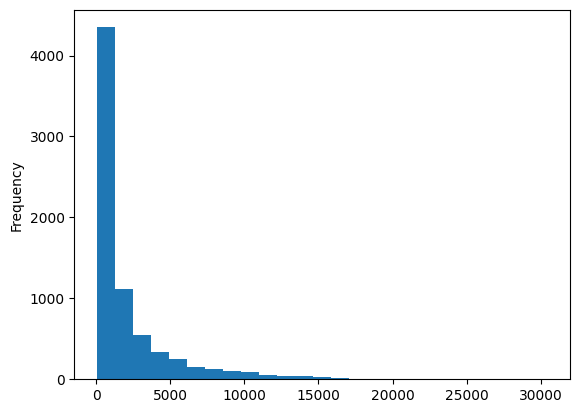

In [56]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

##### Casos para corte dos passageiros validos

- Ha casos em que a duracao conexao de um passageiro eh superior a 47000 segundos (12h)
    - isso ocorre para passageiros que usam a linha diariamente
    - assim a dataInicio ocorre no fim de um dia e a dataFim no inicio de outro
- Com isso deve-se faze rum corte para retirar essas anomalia

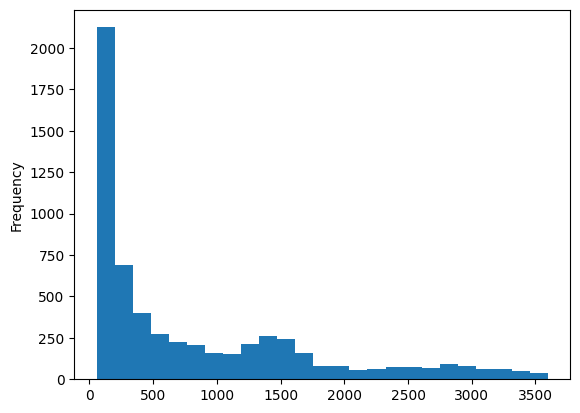

In [57]:
julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

#### Histograma Distance 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

##### Conclusao: Absoluta concentracao viagens de curta ducarao (ate 10 minutos)

    - 95% percentil de viagens é de 2km
    - Sao 230 viagens com mais de 2km, razoavel retirar sujeira

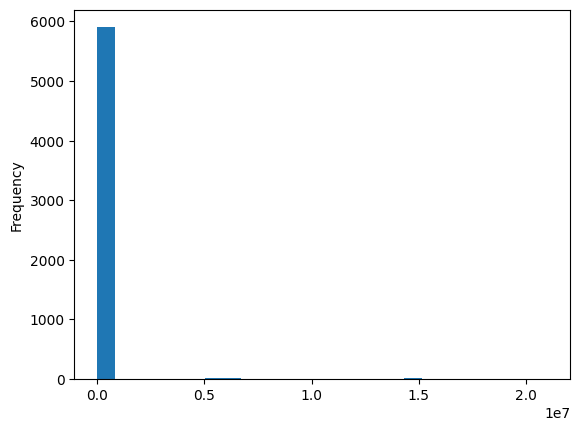

In [58]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].plot(kind='hist', bins = 25);

In [59]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    5.981000e+03
mean     1.130458e+05
std      1.095553e+06
min      3.001005e+02
25%      4.432059e+02
50%      6.329188e+02
75%      9.964098e+02
80%      1.104088e+03
85%      1.307512e+03
90%      1.544465e+03
95%      2.012182e+03
max      2.100980e+07
Name: distance(m), dtype: float64

In [60]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 2000   )  ) ]

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
317,1,206,Manha,2021-07-01 07:42:39,2021-07-01 12:56:39,6,2399.170731,1214.0,-22.829061,-47.065675,-22.827753,-47.066932
1573,1,1142,Manha,2021-07-01 11:02:31,2021-07-01 11:14:47,2,2225.722639,623.0,-22.816172,-47.072777,-22.829565,-47.062298
2713,1,2139,Manha,2021-07-01 12:23:06,2021-07-01 12:54:35,2,2491.700509,1447.0,-22.815199,-47.072564,-22.830538,-47.062144
2755,1,2172,Manha,2021-07-01 12:34:31,2021-07-01 12:53:35,1,2362.167745,1144.0,-22.816388,-47.072652,-22.831650,-47.062896
4569,1,3956,Tarde,2021-07-01 17:50:10,2021-07-01 17:57:05,1,2492.215995,415.0,-22.813829,-47.070396,-22.831374,-47.063410
...,...,...,...,...,...,...,...,...,...,...,...,...
158529,30,8894,Manha,2021-07-30 07:21:50,2021-07-30 11:15:16,2,2205.756264,698.0,-22.820417,-47.068287,-22.829757,-47.061945
158578,30,9594,Manha,2021-07-30 06:50:23,2021-07-30 12:56:11,8,4633.145681,3488.0,-22.827975,-47.066794,-22.829650,-47.061526
159181,30,21352,Manha,2021-07-30 12:04:43,2021-07-30 12:16:41,2,2167.897062,794.0,-22.816561,-47.072670,-22.823024,-47.061946
159554,30,38678,Manha,2021-07-30 07:04:57,2021-07-30 12:17:08,11,3547.254494,2300.0,-22.816088,-47.062540,-22.813772,-47.063343


In [61]:

julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 2000   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    3.040000e+02
mean     2.210470e+06
std      4.363229e+06
min      2.001098e+03
25%      2.171188e+03
50%      2.445120e+03
75%      3.052282e+06
80%      5.847510e+06
85%      6.086021e+06
90%      8.113475e+06
95%      1.480257e+07
max      2.100980e+07
Name: distance(m), dtype: float64

### Passageiros Validos

Foi adotado a duracao das viagens entre 60s e 1h

e com distancia percorrida entre 300m e 2,125km



In [62]:
validas_julho = julho_coordenadas.loc[  ((  julho_coordenadas['duration(s)'] > 60   ) & (  julho_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  julho_coordenadas['distance(m)'] > 300  ) & (  julho_coordenadas['distance(m)'] < 2125   )  )].reset_index(drop=True).reset_index()
validas_julho

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,0,1,13,Tarde,2021-07-01 14:37:45,2021-07-01 18:42:57,4,502.356371,686.0,-22.820898,-47.068038,-22.821202,-47.067482
1,1,1,30,Manha,2021-07-01 07:34:26,2021-07-01 07:51:34,1,933.964936,1028.0,-22.816837,-47.066229,-22.813916,-47.059323
2,2,1,42,Tarde,2021-07-01 13:49:55,2021-07-01 18:47:43,6,609.155101,525.0,-22.819356,-47.064788,-22.818738,-47.065551
3,3,1,54,Manha,2021-07-01 07:35:50,2021-07-01 09:24:32,3,384.159403,713.0,-22.820116,-47.068206,-22.821456,-47.067986
4,4,1,54,Tarde,2021-07-01 13:38:38,2021-07-01 19:06:26,4,641.227579,1276.0,-22.819642,-47.067451,-22.820007,-47.068044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5727,5727,30,90609,Tarde,2021-07-30 14:45:53,2021-07-30 14:47:18,1,521.938710,85.0,-22.829397,-47.064971,-22.825827,-47.066712
5728,5728,30,90693,Tarde,2021-07-30 16:09:42,2021-07-30 16:10:52,1,514.400222,70.0,-22.825313,-47.066418,-22.829124,-47.065770
5729,5729,30,90858,Tarde,2021-07-30 16:58:11,2021-07-30 17:01:32,1,1285.628412,201.0,-22.820682,-47.068155,-22.829885,-47.065038
5730,5730,30,91310,Tarde,2021-07-30 19:09:18,2021-07-30 19:11:38,1,1020.777095,140.0,-22.824714,-47.065161,-22.831899,-47.062296


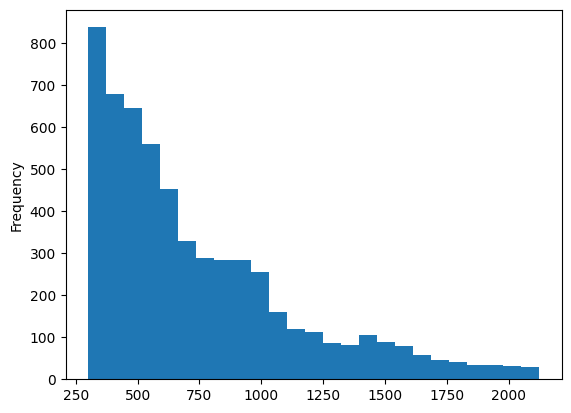

In [63]:
validas_julho['distance(m)'].plot(kind='hist', bins = 25);

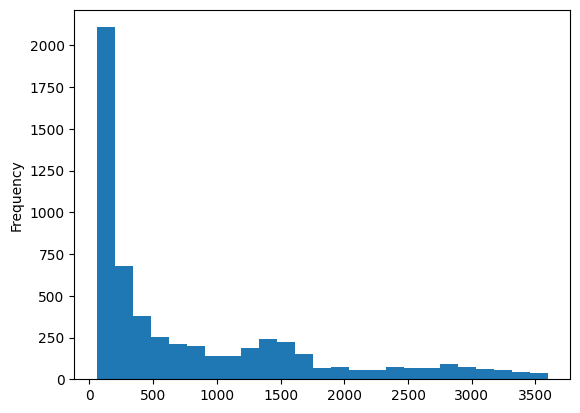

In [64]:
validas_julho['duration(s)'].plot(kind='hist', bins = 25);

In [65]:
# validas_julho.to_excel('viagens_validas_julho.xlsx', engine = 'openpyxl')

In [66]:
validas_julho.loc[((validas_julho['dataFim'] - validas_julho['dataInicio']).dt.total_seconds()  < validas_julho['duration(s)'])]

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
305,305,2,769,Manha,2021-07-02 12:12:17,2021-07-02 12:13:37,2,620.594334,85.0,-22.818392,-47.063936,-22.814128,-47.064462
306,306,2,769,Manha,2021-07-02 12:12:17,2021-07-02 12:13:37,2,620.594334,85.0,-22.818392,-47.063936,-22.814385,-47.064279
343,343,2,2129,Manha,2021-07-02 11:56:32,2021-07-02 12:22:34,2,442.521330,1627.0,-22.814295,-47.071676,-22.815306,-47.072602
425,425,2,6722,Manha,2021-07-02 12:10:35,2021-07-02 12:23:22,2,1019.938578,793.0,-22.821589,-47.068506,-22.816493,-47.072830
426,426,2,6725,Manha,2021-07-02 12:11:11,2021-07-02 12:12:48,2,938.441991,107.0,-22.821312,-47.067763,-22.815939,-47.063624
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087,5087,27,9021,Manha,2021-07-27 12:51:33,2021-07-27 12:57:35,2,496.004625,387.0,-22.826962,-47.067619,-22.824962,-47.065635
5092,5092,27,9848,Manha,2021-07-27 08:15:05,2021-07-27 08:27:12,2,1471.325150,744.0,-22.816368,-47.072670,-22.825442,-47.066500
5103,5103,27,12585,Manha,2021-07-27 12:34:02,2021-07-27 12:58:02,2,357.678425,1472.0,-22.829525,-47.064022,-22.829137,-47.065721
5424,5424,29,3807,Tarde,2021-07-29 17:05:18,2021-07-29 17:12:54,2,439.821246,464.0,-22.824934,-47.065609,-22.823528,-47.068413


In [67]:
validas_julho.device_id.value_counts()

390      37
554      37
333      36
354      36
408      34
         ..
34501     1
34220     1
33827     1
32665     1
91318     1
Name: device_id, Length: 2189, dtype: int64

## validas_julho

In [68]:
validas_julho.groupby(pd.Grouper(key='dataInicio', freq='1h')).agg(   {
                                                                          'sequence':'count'
}    )#.plot(kind='bar');

,sequence
dataInicio,
2021-07-01 07:00:00,48
2021-07-01 08:00:00,9
2021-07-01 09:00:00,9
2021-07-01 10:00:00,0
2021-07-01 11:00:00,8
...,...
2021-07-30 15:00:00,1
2021-07-30 16:00:00,6
2021-07-30 17:00:00,8


## Continuacao

- com os pontos de chegada e saida das viagens validas 
- agrupar os pontos por intervalo de tempo (aqui vai ficar a parametrizacao)
- dai para cara intervalo horario vamos ter uma tabela esparsa de origem destino

    - Serao 2 picos, manha e tarde
    - por dia sao 2 matrizes origem/destino
    - sao, em media, 20 dias por mes
    - potencialmente 60 matrizes
    